# 利用最简单的回归模型看一下上证综指的婴儿底到底在哪里

## 基本结论：
- 在2016年底，平均的预期股指底部在2694点左右。
- 在2016年底，出现比2048更低的最低值的概率有15%。但是同样有15%的概率，股指会一直大于3340。

## 分析模型假设：
- 股指是按照指数增长,也就是 y=e^x。这个假定太简单，以至于我都没法从学术论文里面找到什么人这么玩。不过直观上看，相信只要中国的GDP按照指数增长，股指也应该类似按照指数增长。因为最后不管是政府撒钱搞通胀，还是实体经济真正增长，只要GDP增长，社会的名义财富增长，那么股指应该是上涨的。这个假定应该只对一段时间有用，比如对于日本这种变成负增长的经济体可能就不成立。所以大家看这个结论的时候可以自己掂量。
- 随机因素我们假定按照正态分布，也就是真实的股指底部将按照股指底部的期望值上下服从高斯正态分布。
- 最底部的数值是相对稳定的，而最大值是变化更大的。所以本文的模型集中分析股指最底部。



简单讲这里就是***一个指数增长模型和一个正态分布模型的组合***。这个分析模型是用Jupyter创建的。如果你需要本地运行并验证这个模型，可以下载[Anaconda](https://www.continuum.io/downloads)安装后就有Jupyter，应该就能跑了，如果发现缺的，就用pip安装缺的包就可以了。

## 下面是具体的模型分析：

In [22]:
import pandas.io.data as web
import datetime
import pandas as pd
import scipy
import numpy as np 
from scipy.optimize import curve_fit


import matplotlib.pyplot as plt
%matplotlib inline

我们的第一步是下载股票指数，这里用Pandas自带的DataReader来读取股票数据。 大概看了一下后，似乎1992年之前股指有个很大的跳升，作为非专业人士，也不知道发生了什么，所以就从看着比较合适的1992年开始到现在进行分析。

In [23]:
start = datetime.datetime(1992, 8, 12)
end = datetime.datetime(2016, 5, 20)


# If you want to run this notebook at your local instance, uncomment those lines of code and fetch the latest index from Yahoo again.
# Refer to:  http://pandas.pydata.org/pandas-docs/stable/remote_data.html
shanghai = web.DataReader("000001.SS", 'yahoo', start, end)

#shanghai.to_csv('C:\qduan\Stanmo\stock_minima\shanghai_index_1992_2016.csv')

# I saved and reloaded from this location as a cache for my testing purpose.
#shanghai = pd.DataFrame.from_csv('C:\qduan\Stanmo\stock_minima\shanghai_index_1992_2016.csv')
#print(shanghai.count())


要分析股指对于时间的增长，我们需要把时间转换成做一个实数联系续增长的间隔天数，也就是从开始的1992年开始到每一天的间隔天数"days"。我们假定股指是某一个增长率每天"days"增长的。
然后我们可以简单看一下下载并转换后的数据结构，基本上世界上所有的股票都是监控这几个指标，其中我们将重点分析最低价格"Low"。

In [24]:
sh = shanghai.copy()
sh['date1'] = shanghai.index
#http://chrisalbon.com/python/pandas_apply_operations_to_dataframes.html
sh['days'] = sh['date1'].apply(lambda x:  (x-start).days)
sh.head()

,Open,High,Low,Close,Volume,Adj Close,date1,days
Date,,,,,,,,
1992-08-12,781.21,781.21,781.21,781.21,0,781.21,1992-08-12,0
1992-08-13,850.94,850.94,850.94,850.94,0,850.94,1992-08-13,1
1992-08-14,858.38,858.38,858.38,858.38,0,858.38,1992-08-14,2
1992-08-17,939.46,939.46,939.46,939.46,0,939.46,1992-08-17,5
1992-08-18,933.44,933.44,933.44,933.44,0,933.44,1992-08-18,6


下面我们首先利用scipy.argrelextrema找出所有历史上的最低点。这个定义也是我自己瞎拍的，如果大家要自己试一下，可以选择其他更加严格或者放松的参数。
我定义的历史最低点是在前轴100个交易日内都没有比当前点位更低的交易日，那么我就认为是一个局部最小了。
exp_func函数就是我们假定股指服从的分布，a * np.exp(b * x)，我们需要做的是根据历史上所有最小值来训练出合适的a和b，从而得到一个合理的股指最小值的预测。
训练的过程我们还是使用scipy里面的curve_fit函数，curve_fit(exp_func, x_minima, y_minima)。 后面的p0参数是之前训练的时候的输出，从这个开始的话收敛会比较快。

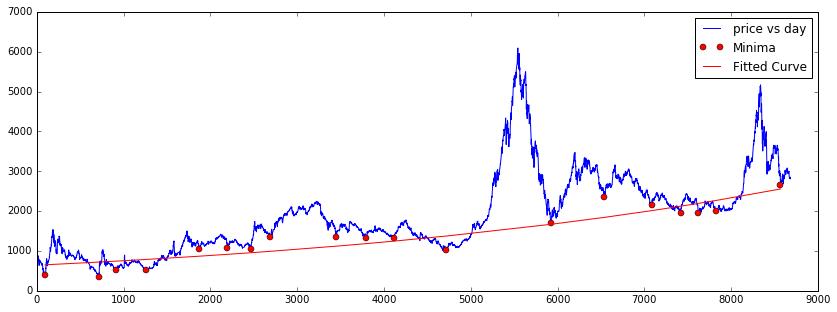

In [25]:

x_all = sh['days'].values
y_all = sh['Low'].values

# with help of scipy.argrelextrema function, we will first identify all the local minima for later on fitting.
# http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.signal.argrelextrema.html
from scipy.signal import argrelextrema
local_min_ix =  argrelextrema(y_all, np.less,   order=100)

x_minima=x_all[local_min_ix]
y_minima=y_all[local_min_ix]

def exp_func(x, a, b, c):
    return a * np.exp(b * x)
popt_minima, pcov_minima = curve_fit(exp_func, x_minima, y_minima, p0=[ 5.69396441e+02,   1.93941219e-04,   2.25849076e+02])

plt.figure(figsize=(14,5))
plt.plot(x_all, y_all, 'b-', label="price vs day") 
plt.plot(x_minima, y_minima, 'ro', label="Minima") 
plt.plot(x_minima, exp_func(x_minima, *popt_minima), 'r-', label="Fitted Curve")
plt.legend()
plt.show()



上面的得到的图里面红色的圆点就是每一次的上证最小值。至此，我们已经可以得到在2016年底12月24日（days=8900)股指底部大约应该在2694点，基本是五五开的概率。有50%的概率会出现低于这个值的情况，也有50%的可能永远都高于这个值。

In [26]:
## Then we know the expected low end of shanghai index as: 
print( exp_func(8900, *popt_minima))

2694.47642153


红线是根据前面指数模型训练得到的股指底部的模型预测值。下面的X周仍然是价格天数，不容易看，所以下面转成原始的日期。然后我们增加未来每6个月的时间节点，预测一下股指可能的底部。

In [27]:
df = pd.DataFrame({'days': x_minima, 'predicted_low':exp_func(x_minima, *popt_minima) })
predicted_df = pd.merge(sh, df, on=['days','days'])

new_day = 8900
predicted_df.loc[start+datetime.timedelta(days=new_day)] =[-1, -1, -1, -1, 0, -1,  start+datetime.timedelta(days=new_day), new_day, exp_func(new_day, *popt_minima)]  # ['predicted_low'] 
new_day = 9060
predicted_df.loc[start+datetime.timedelta(days=new_day)] =[-1, -1, -1, -1, 0, -1,  start+datetime.timedelta(days=new_day), new_day, exp_func(new_day, *popt_minima)]  # ['predicted_low'] 
new_day = 9250
predicted_df.loc[start+datetime.timedelta(days=new_day)] =[-1, -1, -1, -1, 0, -1,  start+datetime.timedelta(days=new_day), new_day, exp_func(new_day, *popt_minima)]  # ['predicted_low'] 

x_extended=np.append(  x_all[local_min_ix], [8900, 9000, 9100] )

虽然前面的预测模型能够给出大概的一个预测值，但是可能还不够精确。所以为了能够更精确的量化底部每个数值可能出现的概率，针对所有的底部我们再训练一个正态分布模型，看看历史上的底部偏离当前模型最多能偏离多少。

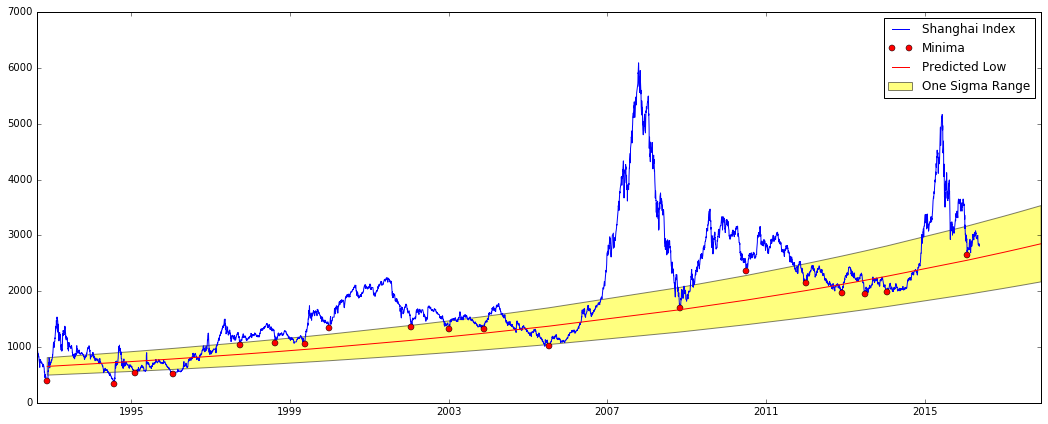

In [28]:

# Calculate the deviations from exponential model according to historical minima
data =( exp_func(x_minima, *popt_minima)-y_minima ) / exp_func(x_minima, *popt_minima)
# Fit a normal distribution to the historical deviations.
mu, std = scipy.stats.norm.fit(data) 

# Compute the boundary for later ploting.
predicted_df['lower_bound'] = predicted_df['predicted_low'].values *(1-std)
predicted_df['upper_bound'] = predicted_df['predicted_low'].values *(1+std)

plt.figure(figsize=(18,7))
plt.plot(sh['date1'].values, y_all, 'b-', label="Shanghai Index") 
plt.plot(predicted_df[predicted_df.date1<=end]['date1'].values, predicted_df[predicted_df.date1<=end]['Low'].values, 'ro', label="Minima") 
plt.plot(predicted_df['date1'].values, predicted_df['predicted_low'].values, 'r-', label="Predicted Low")

plt.fill_between(predicted_df['date1'].values, 
                 predicted_df['lower_bound'].values, 
                 predicted_df['upper_bound'].values, 
                 facecolor='yellow', alpha=0.5, label='One Sigma Range')
plt.legend()
plt.show()

 

In [29]:
# 下面这个表格基本就是上面图里面的数据，不过更容易看一点。
# Now we check a few statistics and first of all those are the data of previous chart:
predicted_df[['date1','days','Low', 'predicted_low','lower_bound','upper_bound']]

,date1,days,Low,predicted_low,lower_bound,upper_bound
0,1992-11-17,97,393.52,652.277070,495.942278,808.611862
1,1994-07-29,716,333.92,720.693024,547.960608,893.425439
2,1995-02-07,909,532.49,743.458345,565.269641,921.647049
3,1996-01-22,1258,516.46,786.466071,597.969471,974.962670
4,1997-09-23,1868,1041.97,867.697545,659.731757,1075.663334
5,1998-08-17,2196,1070.41,914.791498,695.538446,1134.044550
6,1999-05-18,2470,1059.87,956.085868,726.935570,1185.236166
7,1999-12-27,2693,1345.35,991.066166,753.531950,1228.600383
8,2002-01-22,3450,1358.69,1119.639539,851.289443,1387.989635
9,2003-01-03,3796,1319.87,1183.836251,900.099780,1467.572721


上面的图中，黄色区域的上下界分别是股指底部可能上下浮动的一倍Sigma的区间。其实，大部分的时候(70%)，股指底部是出现在这个区间的。肯定有人会问的是，股指底部继续向下跌穿2048的概率是多少呢？

这个问题，翻译过来就是，一个值如果低于1倍的Sigma，出现的概率是多少呢？大概是这个数：

In [30]:
print(scipy.stats.norm(mu, std).cdf(mu-std))
print(scipy.stats.norm(mu, std).cdf(mu+std))


0.158655253931
0.841344746069


也就是说在2016年底，<font color='red'>出现比2048更低的最低值的概率有15%。但是同样有15%的概率，股指是会一直大于3340。</font> 

#我们来看一个统计情况：
首先看一下隔多久出现一次最低值。根据下面的计算，大概最小的是193个交易日，相隔最久的是1212个交易日。我们再来看一下一年多少个交易日。根据
[这个链接](http://zhidao.baidu.com/question/347142653.html) ，
2001年至2010年十年间年平均交易日是240.8天。2010年的交易日是242天。不过由于周末与年的频率不一致，所以每年可能会由1天左右的上下浮动，所以比较准确的说法是(241±1)天。。

也就是说最长5年里面一个最低值。5年内一直不出现最低值，应该就是传说中的牛市了吧。

In [31]:
# Identify the interval of each minima
print(np.diff(x_minima))
print(np.amin(np.diff(x_minima)))
print(np.amax(np.diff(x_minima)))

[ 619  193  349  610  328  274  223  757  346  319  601 1212  608  549  333
  206  207  738]
193
1212


#后记

现在非常后悔博士论文的时候用Matlab做各种实验，等毕业了就发现其实企业界里面买个Matlab许可其实挺贵的。Python挺好使的，但是刚开始用的时候，很多东西都需要不断的google，stackoverflow，速度回比较慢。如果博士用python做论文的实验，现在也该非常熟练了。所以如果有学生看到这里，就赶紧用Python吧，就算Matlab免费给你，或者盗版很容易，也不要去用啦。


好了，就先练习到这里吧。以后再找别的有意义的专题练习。